In [1]:
from ase import io
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants

In [2]:
from toolbox.calculator.elecpot import ElecPotentialCalculator
from toolbox.io.cp2k import Cp2kHartreeCube
from toolbox.utils.math import gaussian_int

from toolbox import plot

In [3]:
plot.use_style("pub")

In [4]:
coeff = constants.physical_constants['Bohr radius'][0] / constants.angstrom

In [5]:
atoms = io.read("coord.xyz")
wannier_atoms = io.read("wannier.xyz")
extended_atoms = atoms + wannier_atoms
extended_atoms.set_pbc(True)
extended_atoms.wrap()

# spread [Bohr^2]
spread = 1.8816357541

# setup grid
l_box = atoms.cell.cellpar()[2]
cell = atoms.get_cell()
cross_area = np.linalg.norm(np.cross(cell[0], cell[1]))
volume = cross_area * l_box
dx = 1e-3  # Grid spacing
grids = np.arange(0., l_box, dx)
grid_edges = np.linspace(0., l_box, len(grids) + 1)
grid_volume = cross_area * dx

# set up charges
charges = extended_atoms.get_initial_charges().reshape(-1)
charges[extended_atoms.symbols == "O"] = 6.0
charges[extended_atoms.symbols == "H"] = 1.0
charges[extended_atoms.symbols == "X"] = -2.0
extended_atoms.set_initial_charges(charges)

# set up Gaussian width [angstrom]
g_spreads = np.zeros_like(charges)
g_spreads[extended_atoms.symbols == "O"] = 0.244554 * coeff
g_spreads[extended_atoms.symbols == "H"] = 0.200000 * coeff
g_spreads[extended_atoms.symbols == "X"] = np.sqrt(spread / 3) * coeff

In [6]:
rho = []
grid_edges = np.reshape(grid_edges, (1, -1))
g_spreads = np.reshape(g_spreads, [-1, 1])
mu = extended_atoms.positions[:, 2].reshape(-1, 1)
# nat * ngrid
out = gaussian_int(grid_edges[:, 1:], mu, g_spreads) - gaussian_int(grid_edges[:, :-1], mu, g_spreads)
out = np.sum(out * charges.reshape(-1, 1), axis=0)
rho = out / grid_volume

In [7]:
calculator = ElecPotentialCalculator(rho, grids)
phi = calculator.calculate(l_box=l_box)
# phi -= phi[0]

| | FFT took 0.008177911000000648 s
| | k-space arithmetics took 0.000615135999996852 s
| | Inverse FFT took 0.005876686999997105 s


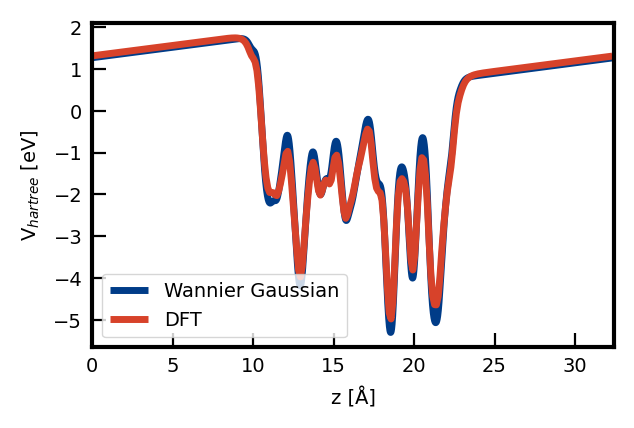

In [8]:
fig, ax = plt.subplots(figsize=[3, 2])

ax.plot(grids, -phi, color="blue", label="Wannier Gaussian")

# cube = Cp2kHartreeCube("cp2k-v_hartree-1_0.cube")
# out = cube.get_ave_cube()
# np.save("hartree_cube.npy", out)
out = np.load("hartree_cube.npy")
ax.plot(out[0], out[1], color="red", label="DFT")

plot.ax_setlabel(ax, "z [Å]", r"V$_{hartree}$ [eV]")
ax.set_xlim(0., l_box)

ax.legend()
fig.savefig("wc_spread_hartree.png", transparent=True)

plt.show()